
Quote from the website:

This data originally came from Crowdflower's Data for Everyone library.

As the original source says,

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

The data we're providing on Kaggle is a slightly reformatted version of the original source. It includes both a CSV file and SQLite database. The code that does these transformations is available on GitHub

For example, it contains whether the sentiment of the tweets in this set was positive, neutral, or negative for six US airlines:



URL: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

Data dictionary:

tweed_id:                   ID of the Tweet.
airline_sentiment:          Labelled column for the sentiment of the Tweet itself. This is the target attribute of the dataset.
negative_reason:            Reasons if the sentiment is negative.
negativereason_confidence:  The confidence of negative reason.
airline:                    Name of the airline.
airline_sentiment_gold:     Sentiment about the airline.
name:                       Username of the tweet.
negativereason_gold:        Reason of negative.
retweet_count:              Number of retweets.
text:                       Content of the tweet.
tweet_coord:                coordination of the Tweet.
tweet_created:              Date and time when the Tweet is made.
tweet_location:             Place when the Tweet is made.
user_timezone:              Timezone of the user.




In [61]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Text Preprocessing
import re
import string
import contractions
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Class balancing
from imblearn.over_sampling import SMOTE

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
recall_score, accuracy_score, confusion_matrix,
classification_report, f1_score, precision_score,
precision_recall_fscore_support
)
from sklearn.model_selection import cross_val_score


# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# BERT and TensorFlow
from transformers import BertTokenizer, TFBertForSequenceClassification, TFTrainer, TFTrainingArguments
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from kerastuner.tuners import RandomSearch
from keras.wrappers.scikit_learn import KerasClassifier

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Word Cloud
from wordcloud import STOPWORDS, WordCloud

# Configuration
# Remove the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Set the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/teohkhenghong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/teohkhenghong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/teohkhenghong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('Tweets.csv')

In [3]:
print(df.shape)
df.head()

(14640, 15)


tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

Analysis: Based on the execution output, there are 14,640 records in the dataset, with 15 attributes/columns.



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [5]:
# Check for empty values in each column.
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

Analysis: There are some missing values in some columns,

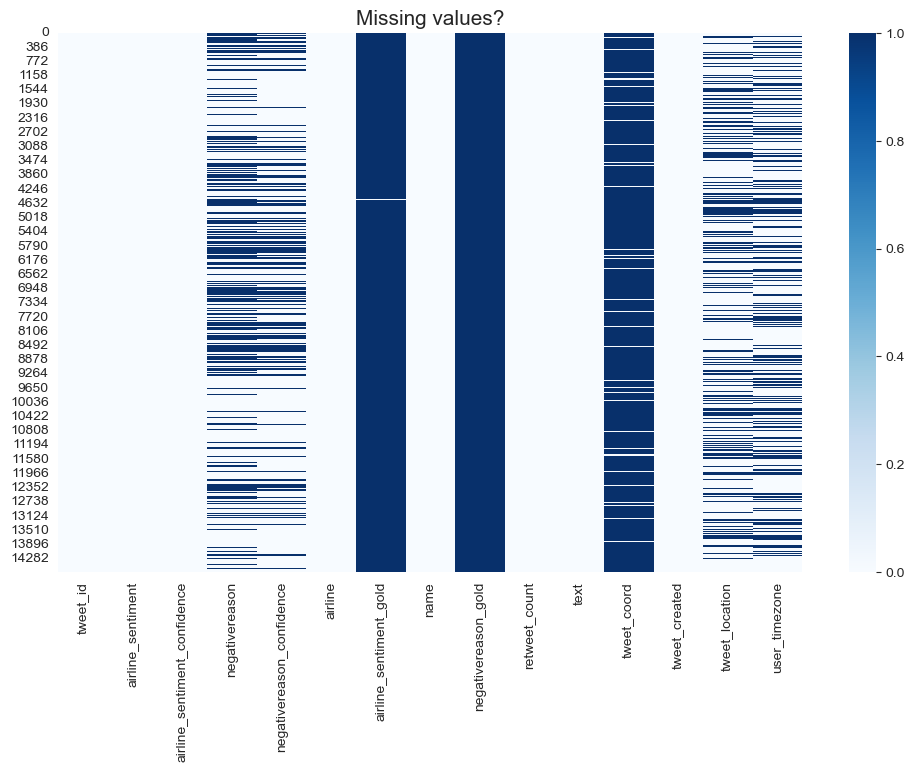

In [6]:
plt.figure(figsize=(12,7))
sns.heatmap(df.isnull(), cmap = "Blues") #Visualization of missing value using heatmap
plt.title("Missing values?", fontsize = 15)
plt.show()

Analysis: The heatmap above shows the missing values' distribution in the dataset. The darker the value

In [7]:
print("Percentage null or na values in df")
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

Percentage null or na values in df


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

Analysis: From the above, airline_sentiment_gold, negativereadson_gold and twwet_coord have 99.73%, 99.78% and 93.04% missing values respectively.

Hence, remove the columns that have most of the distribution with empty values to improve the data quality, computational efficiency, interpretability of the dataset for the model building process later.

In [8]:
# Drop unnecessary columns
df.drop(columns=['tweet_coord', 'airline_sentiment_gold', 'negativereason_gold'], inplace=True)
df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline        name  \
0            NaN                        NaN  Virgin America     cairdin   
1            NaN                     0.0000  Virgin America    jnardino   
2            NaN                        NaN  Virgin America  yvonnalynn   
3     Bad Flight                     0.7033  Virgin America    jnardino   
4     Can't Tell                     1.0000  Virgin America    jnardino   

   retweet_count                                               text  \
0              0                @VirginAmerica What @dhepburn said.   
1              0  @VirginAmerica plus you've added commercials t...   
2              0  @VirginAmerica I didn't today... Must mean I n...   
3              0  @VirginAmerica it's really aggressive to blast...   
4              0  @VirginAmerica and it's a really big bad thing...   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [9]:
negativereason_freq = df.groupby('negativereason').size()

In [10]:
negativereason_freq

negativereason
Bad Flight                      580
Can't Tell                     1190
Cancelled Flight                847
Customer Service Issue         2910
Damaged Luggage                  74
Flight Attendant Complaints     481
Flight Booking Problems         529
Late Flight                    1665
Lost Luggage                    724
longlines                       178
dtype: int64

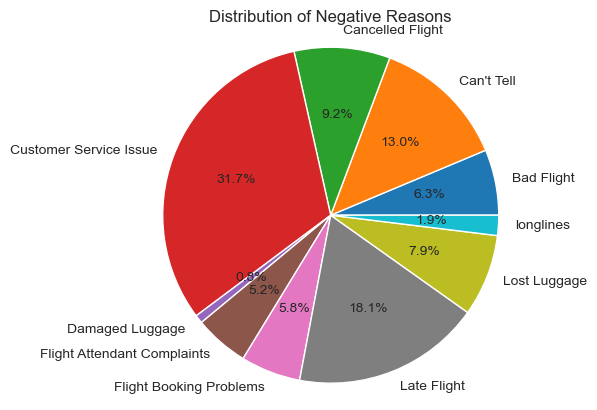

In [11]:
# Extract the unique values and their frequencies
labels = negativereason_freq.index
sizes = negativereason_freq.values

# Plot the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Negative Reasons')

# Display the chart
plt.show()

Analysis: Diving into the negativereasons column, customer service issue attributes 31.7% of the distribution, 18.1% of Late Flight, which covers almost 50% of the distribution. Followed by 13.0% Can't tell, 9.2% Cancelled Flight, combined with first 2 main reasons, they have covered 70% of the negative sentiments of the customers.

# Check Record duplicates

In [12]:
df.duplicated().sum()

39

Analysis: Based on the output above, there are 39 duplicates found in the dataset.

In [13]:
df.drop_duplicates(inplace = True) # Drop duplicates

In [14]:
df.duplicated().sum()

0

Analysis: After the execution, there are no more duplicates in the dataset.

In [15]:
np.random.seed(42)

# also look at random 10 sample rows
df.sample(n=5)

tweet_id airline_sentiment  airline_sentiment_confidence  \
169   569459618881019905           neutral                        1.0000   
9355  569970608693493760          negative                        1.0000   
3013  568800389903962112          negative                        1.0000   
1475  569705838870466561          negative                        0.6939   
7420  569620168671756288           neutral                        0.6376   

               negativereason  negativereason_confidence         airline  \
169                       NaN                        NaN  Virgin America   
9355   Customer Service Issue                     0.6444      US Airways   
3013         Cancelled Flight                     0.3467          United   
1475  Flight Booking Problems                     0.6939          United   
7420                      NaN                     0.0000           Delta   

              name  retweet_count  \
169        NewsSWA              0   
9355     smaguire2              0   
3013    Azraellius              0   
1475  JoeRychalsky              0   
7420  Ben_Harriton              0   

                                                   text  \
169   @VirginAmerica to jump into the Dallas-Austin ...   
9355  @USAirways even if I was the single most unrea...   
3013  @united haha and you have to clean a plane tha...   
1475  @united I can't find any Late Flight evening f...   
7420  @JetBlue of my tray table is broken what do i do?   

                  tweet_created        tweet_location  \
169   2015-02-22 03:32:07 -0800                 FL410   
9355  2015-02-23 13:22:37 -0800                   NaN   
3013  2015-02-20 07:52:35 -0800           Orlando, FL   
1475  2015-02-22 19:50:31 -0800  Wilmington, Delaware   
7420  2015-02-22 14:10:05 -0800                   NaN   

                   user_timezone  
169                       Sydney  
9355      Atlantic Time (Canada)  
3013  Eastern Time (US & Canada)  
1475  Eastern Time (US & Canada)  
7420                         NaN

Analysis: The random seed of the Numpy library is fixed to a constant number before the rest of the modelling process. This is to ensure that the result reproducibility is guaranteed.

This consistency is needed  during the following process:
* Initialization of model weights.
* Splitting data to train and test datasets.
* Generation of random numbers for cross-validation.
* Control variability of the random processes.
* Allow better debugging and troubleshooting.

Analysis: There are still many empty values across from the remaining columns, which will be further analyzed during the Exploratory Data Analysis (EDA) section.

# Exploratory Data Analysis (EDA)

EDA is an important process in pre-data modelling as it analyse the patterns and distributions of the dataset to help understand the dataset deeper and gain insights before ready for modelling process.
Hence, the steps are based on the execution outputs with the recommended approach to ensure data quality is achieved.

In [16]:
# Describe the dataset.
df.describe().T

count          mean           std  \
tweet_id                      14601.0  5.692156e+17  7.782706e+14   
airline_sentiment_confidence  14601.0  8.999022e-01  1.629654e-01   
negativereason_confidence     10501.0  6.375749e-01  3.303735e-01   
retweet_count                 14601.0  8.280255e-02  7.467231e-01   

                                       min           25%           50%  \
tweet_id                      5.675883e+17  5.685581e+17  5.694720e+17   
airline_sentiment_confidence  3.350000e-01  6.923000e-01  1.000000e+00   
negativereason_confidence     0.000000e+00  3.605000e-01  6.705000e-01   
retweet_count                 0.000000e+00  0.000000e+00  0.000000e+00   

                                       75%           max  
tweet_id                      5.698884e+17  5.703106e+17  
airline_sentiment_confidence  1.000000e+00  1.000000e+00  
negativereason_confidence     1.000000e+00  1.000000e+00  
retweet_count                 0.000000e+00  4.400000e+01

Analysis: From the table above, here are the observations:

* tweet_id appears to be unique, as the mean value of 5.69E+17 is very high, which suggests that each Tweet has distinct ID assoociated with it.
* airline_sentiment_confidence has mean value of 0.9 which means that sentiment classification is generally confident.
* negativereason_confidence has mean value of 0.638 suggestsa moderate level of confidence. However, there are lower count (10,501) than overall count (14,601) indicates that there are some missnig attributes in the attribute.
* retweet_count has average value of 0.0828 indicates that most of the tweets have low retweets. But, there are some Tweets got retweeted as high as 44 times.
* tweet_id, airline_sentiment_confidence and retweet_count have no missing values.
* tweet_id, airline_sentiment_confidence and retweet_count have relatively small standard deviations, means the values on these attributes doesn't deviate too far from mean.
* All columns' median (50%) values are bigger than mean, which shows data imbalance.

In [17]:
# Check unique value of airline_sentiment.
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [18]:
airline_sentiment_freq = df.groupby('airline_sentiment').size()

Analysis: airline_sentiment has 3 distinct values, which are neutral, positive and negative.

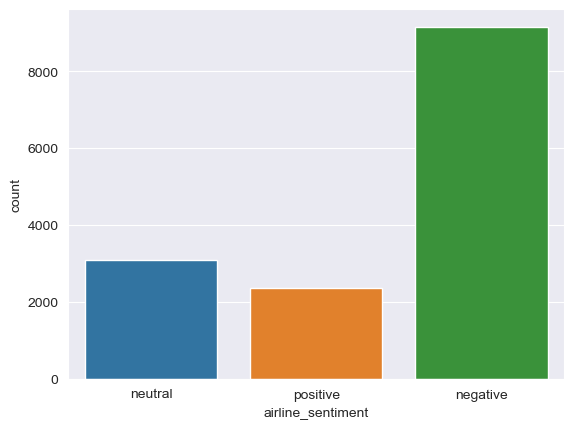

In [19]:
ax = sns.countplot(x="airline_sentiment", data=df)

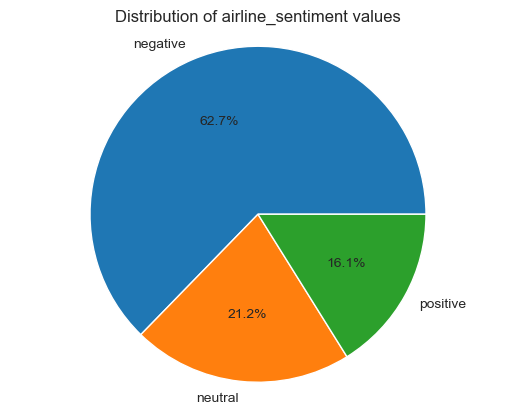

In [20]:
# Extract the unique values and their frequencies
labels = airline_sentiment_freq.index
sizes = airline_sentiment_freq.values

# Plot the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of airline_sentiment values')

# Display the chart
plt.show()

Analysis: There are 62.7 % of negative, 16.1% of positive and 21.2% of neutral sentiments from the airlines that the users have taken.

In [21]:
airline_freq = df.groupby('airline').size()

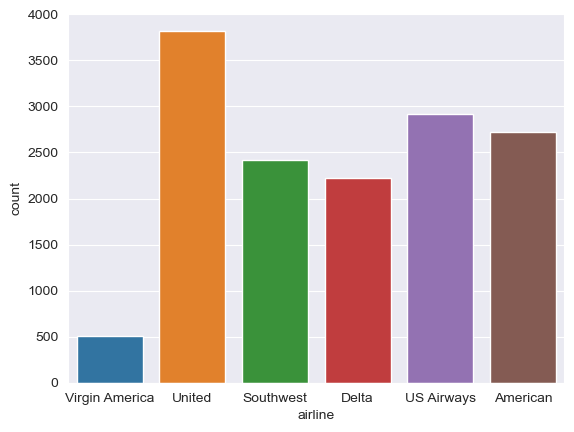

In [22]:
ax = sns.countplot(x="airline", data=df)

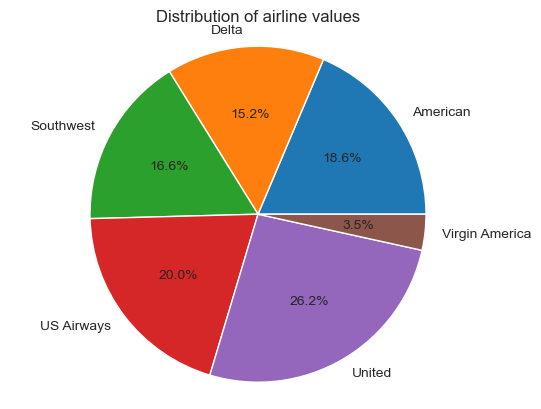

In [23]:
# Extract the unique values and their frequencies
labels = airline_freq.index
sizes = airline_freq.values

# Plot the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of airline values')

# Display the chart
plt.show()

Analysis: The user tweets about the airlines are more distributed, with exception of Virgin America. The airline

In [24]:
# Calculate the cross-tabulation of airline and airline_sentiment
crosstab_sentiments = pd.crosstab(df['airline'], df['airline_sentiment'])
companies = list(crosstab_sentiments.index)

# Create a bar chart for each sentiment category
bar_charts = []
sentiment_labels = list(crosstab_sentiments.columns)
for sentiment_label in sentiment_labels:
    sentiment_values = list(crosstab_sentiments[sentiment_label])
    bar_chart = go.Bar(name=sentiment_label, x=companies, y=sentiment_values)
    bar_charts.append(bar_chart)

# Configure the layout of the figure
layout = go.Layout(
    barmode='stack',
    title='Sentiment Distribution by Airline',
    xaxis=dict(title='Airline'),
    yaxis=dict(title='Sentiment Distribution')
)

# Create the figure with the bar charts and layout
fig = go.Figure(data=bar_charts, layout=layout)

# Show the figure
fig.show()

Analysis: A crossplot has been made to show the sentiments of the Twitter users across the airlines. Based on the above output, most of Tweets are negative about their airlines.

In [25]:
crosstab_neg_reasons = pd.crosstab(df['airline'], df['negativereason'])

print(crosstab_neg_reasons)

negativereason  Bad Flight  Can't Tell  Cancelled Flight  \
airline                                                    
American                87         198               242   
Delta                   64         186                51   
Southwest               90         159               162   
US Airways             104         246               189   
United                 216         379               181   
Virgin America          19          22                18   

negativereason  Customer Service Issue  Damaged Luggage  \
airline                                                   
American                           760               12   
Delta                              199               11   
Southwest                          391               14   
US Airways                         811               11   
United                             681               22   
Virgin America                      60                4   

negativereason  Flight Attendant Complaints  F

In [26]:
# Calculate the cross-tabulation of airline and negative reason
companies = list(crosstab_neg_reasons.index)

# Create a bar chart for each negative reason category
bar_charts = []
reason_labels = list(crosstab_neg_reasons.columns)
for reason_label in reason_labels:
    reason_values = list(crosstab_neg_reasons[reason_label])
    bar_chart = go.Bar(name=reason_label, x=companies, y=reason_values)
    bar_charts.append(bar_chart)

# Configure the layout of the figure
layout = go.Layout(
    barmode='stack',
    title='Negative Reasons Distribution by Airline',
    xaxis=dict(title='Airline'),
    yaxis=dict(title='Negative Reasons Distribution')
)

# Create the figure with the bar charts and layout
fig = go.Figure(data=bar_charts, layout=layout)

# Show the figure
fig.show()

Analysis: Based on the visualization above the most complaint made by the users are the Customer Service Issue, followed by Late Flight.

## Dropping neutral sentiments

Dropping neutral sentiments of the dataset. This is because:
* Reduce dimensionality: The model will only have to predict binary classication task/
* Neutral sentiment does not bring more value for analysis.
* Easier to balance the dataset.

In [27]:
df.drop(df.loc[df['airline_sentiment']=='neutral'].index, inplace=True)

Analysis: Let's try to make a dataset with the Tweet text string and it's sentiment (target variable)

# Wordcloud

To understand the customer most important reason of their sentiments, some visualizations can be made to get the main words from their Tweet mentions, without having to analyze through their Tweets sentences.

In [28]:
data = df[["airline_sentiment", "text"]]
data.head()

airline_sentiment                                               text
1          positive  @VirginAmerica plus you've added commercials t...
3          negative  @VirginAmerica it's really aggressive to blast...
4          negative  @VirginAmerica and it's a really big bad thing...
5          negative  @VirginAmerica seriously would pay $30 a fligh...
6          positive  @VirginAmerica yes, nearly every time I fly VX...

In [29]:
X = df["text"]
y = df["airline_sentiment"]

In [30]:
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
tfidf = TfidfVectorizer(stop_words="english")

In [32]:
tfidf.fit(Xtrain)

TfidfVectorizer(stop_words='english')

In [33]:
print(tfidf.get_feature_names_out())

['00' '000' '000ft' ... 'zv6cfpohl5' 'zvfmxnuelj' 'zzps5ywve2']


In [34]:
print(tfidf.vocabulary_)

{'jetblue': 5633, 'did': 3478, 'idea': 5246, 'offered': 7007, 'pay': 7303, 'tix': 9682, 'airport': 1441, 'bc': 1996, 'told': 9717, 'reservation': 8178, 'didn': 3479, '2275': 394, 'pp': 7562, 'united': 10134, 'guys': 4880, 'suck': 9273, 'respond': 8195, 'friend': 4543, 'lisapal': 6047, 'directly': 3509, 'southwestair': 8993, 'prove': 7740, 'cuz': 3226, 'southwest': 8992, 'people': 7334, 'don': 3654, 'know': 5828, 'schedule': 8525, 'ticket': 9644, 'issued': 5545, 'whilst': 10610, 'delivering': 3377, 'customers': 3210, 'usairways': 10266, 'pilot': 7421, 'flight': 4354, '729': 997, 'departure': 3405, 'amp': 1545, 'broken': 2303, 'computer': 2933, 'time': 9662, 'flying': 4428, 'alwayslate': 1510, 'americanair': 1528, 'point': 7507, 'pic': 7404, 'reps': 8152, 'struggle': 9231, 'merger': 6438, 'imagine': 5284, 'public': 7765, 'http': 5190, 'hqdb5iruvg': 5181, 'thanks': 9552, 'dm': 3619, 'rescheduling': 8171, 'unfortunately': 10121, 'operations': 7076, 'process': 7682, 'lax': 5921, 'chaos': 26

In [35]:
data[data["airline_sentiment"]=="negative"]["text"]

3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
5        @VirginAmerica seriously would pay $30 a fligh...
15           @VirginAmerica SFO-PDX schedule is still MIA.
17       @VirginAmerica  I flew from NYC to SFO last we...
                               ...                        
14631    @AmericanAir thx for nothing on getting us out...
14633    @AmericanAir my flight was Cancelled Flightled...
14634           @AmericanAir right on cue with the delays👌
14636    @AmericanAir leaving over 20 minutes Late Flig...
14638    @AmericanAir you have my money, you change my ...
Name: text, Length: 9157, dtype: object

In [36]:
count_vect = CountVectorizer(stop_words="english")
neg_matrix = count_vect.fit_transform(data[data["airline_sentiment"]=="negative"]["text"])
freqs = zip(count_vect.get_feature_names_out(), neg_matrix.sum(axis=0).tolist()[0])
# Sort from largest to smallest
print(sorted(freqs, key=lambda x: -x[1])[:100])

[('flight', 2937), ('united', 2899), ('usairways', 2375), ('americanair', 2089), ('southwestair', 1214), ('jetblue', 1051), ('cancelled', 921), ('service', 746), ('hours', 646), ('just', 622), ('help', 618), ('hold', 611), ('customer', 609), ('time', 596), ('plane', 530), ('delayed', 505), ('amp', 503), ('hour', 452), ('flightled', 445), ('http', 436), ('flights', 419), ('bag', 415), ('gate', 410), ('ve', 398), ('don', 388), ('late', 377), ('need', 373), ('phone', 367), ('waiting', 341), ('thanks', 315), ('got', 298), ('airline', 294), ('like', 291), ('trying', 288), ('delay', 272), ('wait', 272), ('today', 269), ('minutes', 266), ('day', 251), ('going', 249), ('bags', 245), ('luggage', 245), ('told', 245), ('airport', 244), ('people', 242), ('worst', 241), ('fly', 237), ('really', 236), ('did', 227), ('guys', 224), ('weather', 224), ('lost', 221), ('agent', 218), ('hrs', 217), ('way', 212), ('make', 211), ('change', 210), ('seat', 208), ('flighted', 205), ('want', 205), ('check', 204)

Wordcloud for positive reasons

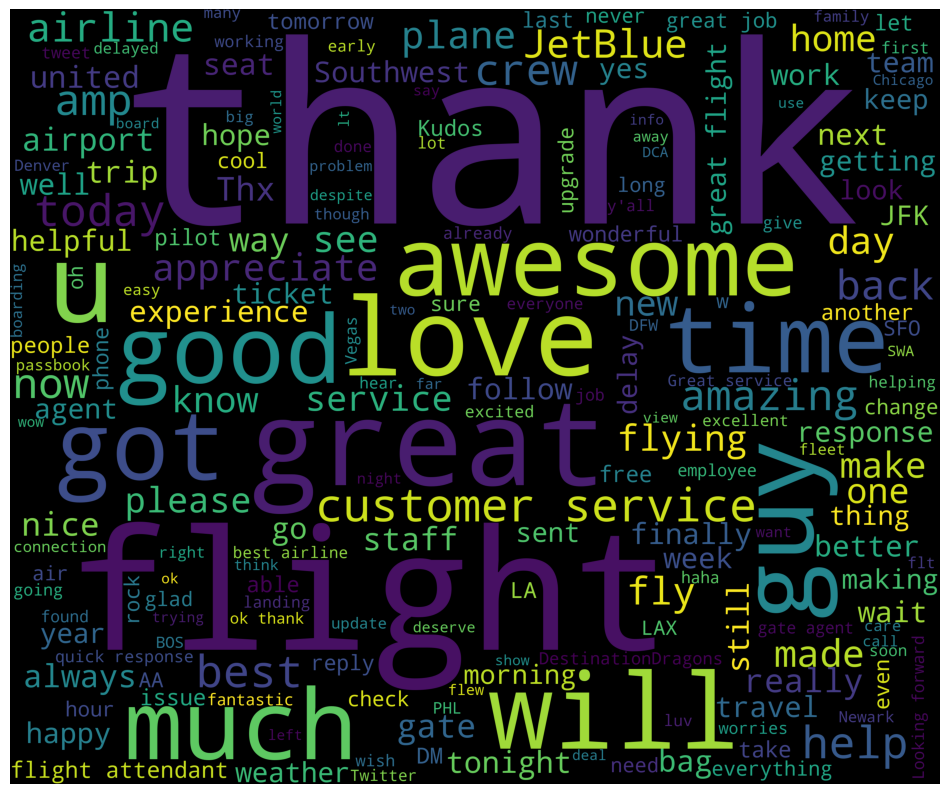

In [37]:
new_df=data[data['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word and not word.startswith('@') and word != 'RT'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',width=3000,height=2500).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Wordcloud for negative reasons

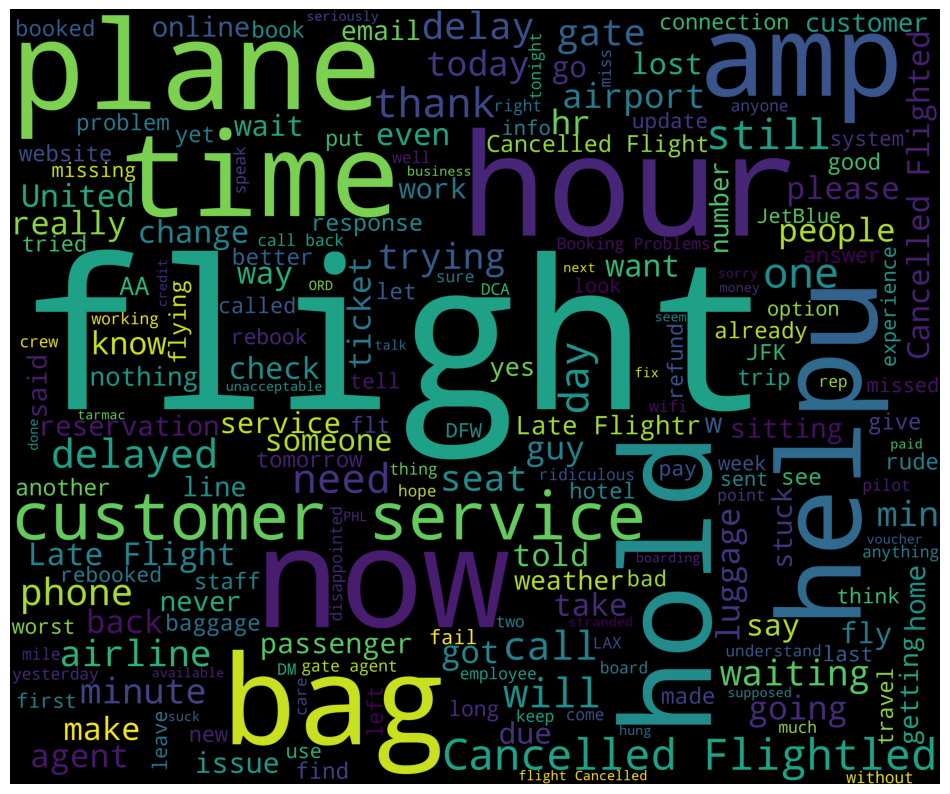

In [38]:
new_df=data[data['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word and not word.startswith('@') and word != 'RT'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',width=3000,height=2500).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [39]:
le = LabelEncoder()
le.fit(df['airline_sentiment'])

df['airline_sentiment'] = le.transform(df['airline_sentiment'])
df.head()

tweet_id  airline_sentiment  airline_sentiment_confidence  \
1  570301130888122368                  1                        0.3486   
3  570301031407624196                  0                        1.0000   
4  570300817074462722                  0                        1.0000   
5  570300767074181121                  0                        1.0000   
6  570300616901320704                  1                        0.6745   

  negativereason  negativereason_confidence         airline        name  \
1            NaN                     0.0000  Virgin America    jnardino   
3     Bad Flight                     0.7033  Virgin America    jnardino   
4     Can't Tell                     1.0000  Virgin America    jnardino   
5     Can't Tell                     0.6842  Virgin America    jnardino   
6            NaN                     0.0000  Virgin America  cjmcginnis   

   retweet_count                                               text  \
1              0  @VirginAmerica plus you've added commercials t...   
3              0  @VirginAmerica it's really aggressive to blast...   
4              0  @VirginAmerica and it's a really big bad thing...   
5              0  @VirginAmerica seriously would pay $30 a fligh...   
6              0  @VirginAmerica yes, nearly every time I fly VX...   

               tweet_created    tweet_location               user_timezone  
1  2015-02-24 11:15:59 -0800               NaN  Pacific Time (US & Canada)  
3  2015-02-24 11:15:36 -0800               NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800               NaN  Pacific Time (US & Canada)  
5  2015-02-24 11:14:33 -0800               NaN  Pacific Time (US & Canada)  
6  2015-02-24 11:13:57 -0800  San Francisco CA  Pacific Time (US & Canada)

# Preprocessing the tweet text data

Now, we will clean the tweet text data and apply classification algorithms on it.

In [40]:
# Define a function for text preprocessing
def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "lxml").get_text()
    # Convert to lowercase
    text = text.lower()
    # Expand contractions
    text = contractions.fix(text)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Stem the words
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    # Join the words back into a single string
    text = " ".join(words)
    return text

In [41]:
df['text']=df['text'].apply(lambda x: preprocess_text(x))

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11510 entries, 1 to 14638
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  11510 non-null  object
 1   text               11510 non-null  object
dtypes: object(2)
memory usage: 269.8+ KB


In [43]:
# Split the dataset into features (X) and target (y)
X = df['text']
y = df['airline_sentiment']
print(len(X), len(y))

11510 11510


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

9208 9208
2302 2302


In [45]:
# Apply TF-IDF Vectorizer to convert text data into numerical features
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Class balancing

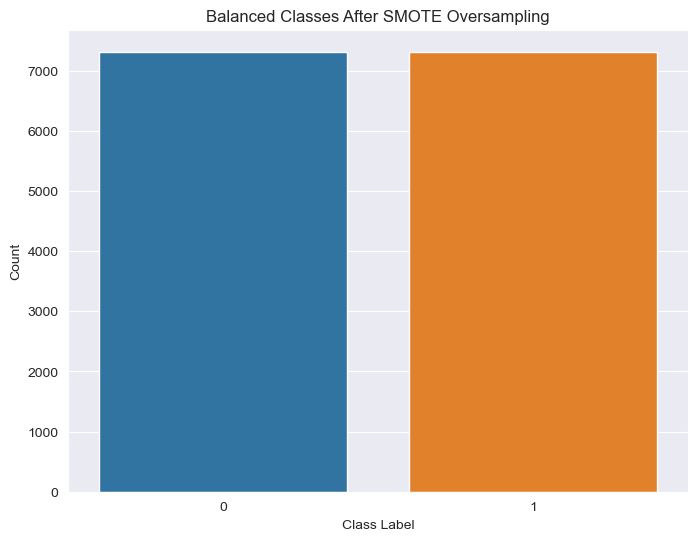

In [46]:
# Step 2: Apply SMOTE to balance the class distribution on the training data
smote = SMOTE(random_state=42)
X_train_tfidf_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

# Count occurrences of each class in the balanced dataset
class_counts = pd.Series(y_train_balanced).value_counts()

# Plot the bar chart to visualize the balanced classes
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Balanced Classes After SMOTE Oversampling')
plt.show()

# Support Vector Machines (SVMs)

In [655]:
# SVM with GridSearch

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 0.01]
}

# Create the SVM model
svm_model = SVC(random_state=42)

# Create the GridSearchCV object
svm_grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit the GridSearchCV to the data
svm_grid_search.fit(X_train_tfidf_balanced, y_train_balanced)

# Get the best parameters and best score
svm_best_params = svm_grid_search.best_params_
svm_best_score = svm_grid_search.best_score_

print("SVM Best Parameters:", svm_best_params)
print("SVM Best Accuracy:", svm_best_score)

SVM Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
SVM Best Accuracy: 0.959183249499039


In [657]:
# Convert the TF-IDF vectorized data to dense matrix
X_train_dense = X_train_tfidf_balanced.toarray()

# Use the best parameters to build the final SVM model
final_svm_model = SVC(**svm_best_params, random_state=42)
final_svm_model.fit(X_train_dense, y_train_balanced)

# Convert the TF-IDF vectorized test data to dense matrix
X_test_dense = X_test_tfidf.toarray()

# Make predictions on the test set using the final SVM model
y_pred_svm = final_svm_model.predict(X_test_dense)

# Calculate evaluation metrics
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm, average="weighted")
svm_recall = recall_score(y_test, y_pred_svm, average="weighted")
svm_f1 = f1_score(y_test, y_pred_svm, average="weighted")

# Print the evaluation metrics
print("SVM Final Model Accuracy:", svm_accuracy)
print("SVM Final Model Precision:", svm_precision)
print("SVM Final Model Recall:", svm_recall)
print("SVM Final Model F1 Score:", svm_f1)

SVM Final Model Accuracy: 0.8922675933970461
SVM Final Model Precision: 0.8956272622448492
SVM Final Model Recall: 0.8922675933970461
SVM Final Model F1 Score: 0.8936942183694554


In [658]:
# Building confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
cm

array([[1703,  141],
       [ 107,  351]])

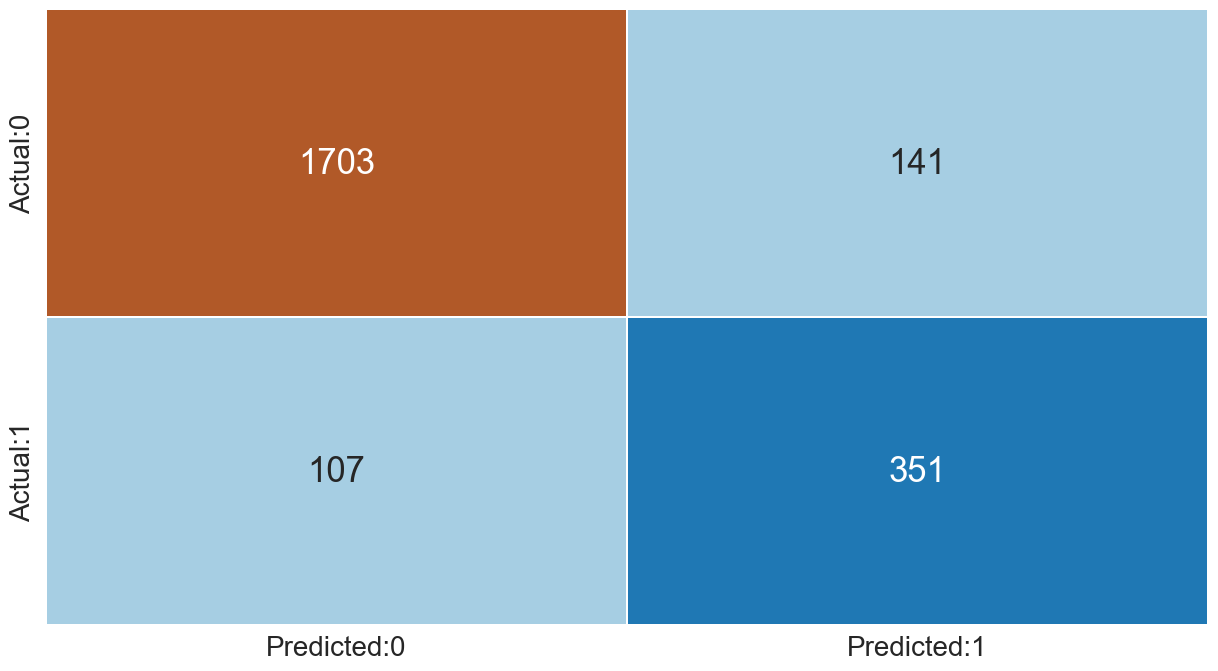

In [659]:
# Defining the size of the canvas
plt.rcParams['figure.figsize'] = [15, 8]

# Confusion matrix to DataFrame
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])

# Plotting the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Paired', cbar=False, linewidths=0.1, annot_kws={'size': 25})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [661]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1844
           1       0.71      0.77      0.74       458

    accuracy                           0.89      2302
   macro avg       0.83      0.84      0.84      2302
weighted avg       0.90      0.89      0.89      2302



As you can see above we have plotted the confusion matrix for predicted sentiments and actual sentiments (negative and positive)
SVM Classifier gives us the best accuracy score i.e 91% precision scores according to the classification report.
The confusion matrix shows the TP,TN,FP,FN for sentiments(negative, positive)

# Random Forest

In [98]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     # 'bootstrap': [True, False]
# }

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit the GridSearchCV to the data
rf_grid_search.fit(X_train_tfidf_balanced, y_train_balanced)

# Get the best parameters and best score
rf_best_params = rf_grid_search.best_params_
rf_best_score = rf_grid_search.best_score_

print("Random Forest Best Parameters:", rf_best_params)
print("Random Forest Best Accuracy:", rf_best_score)

Random Forest Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Best Accuracy: 0.9477690029268977


In [99]:
# Convert the TF-IDF vectorized data to dense matrix
X_train_dense = X_train_tfidf_balanced.toarray()

# Use the best parameters to build the final Random Forest model
final_rf_model = RandomForestClassifier(**rf_best_params, random_state=42)
final_rf_model.fit(X_train_dense, y_train_balanced)

# Convert the TF-IDF vectorized test data to dense matrix
X_test_dense = X_test_tfidf.toarray()

# Make predictions on the test set using the final Random Forest model
y_pred_rf = final_rf_model.predict(X_test_dense)

# Calculate evaluation metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf, average="weighted")
rf_recall = recall_score(y_test, y_pred_rf, average="weighted")
rf_f1 = f1_score(y_test, y_pred_rf, average="weighted")

# Print the evaluation metrics
print("Random Forest Final Model Accuracy:", rf_accuracy)
print("Random Forest Final Model Precision:", rf_precision)
print("Random Forest Final Model Recall:", rf_recall)
print("Random Forest Final Model F1 Score:", rf_f1)

Random Forest Final Model Accuracy: 0.9026933101650738
Random Forest Final Model Precision: 0.8989941020726628
Random Forest Final Model Recall: 0.9026933101650738
Random Forest Final Model F1 Score: 0.8995738820992499


In [100]:
# Building confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
cm

array([[1767,   77],
       [ 147,  311]])

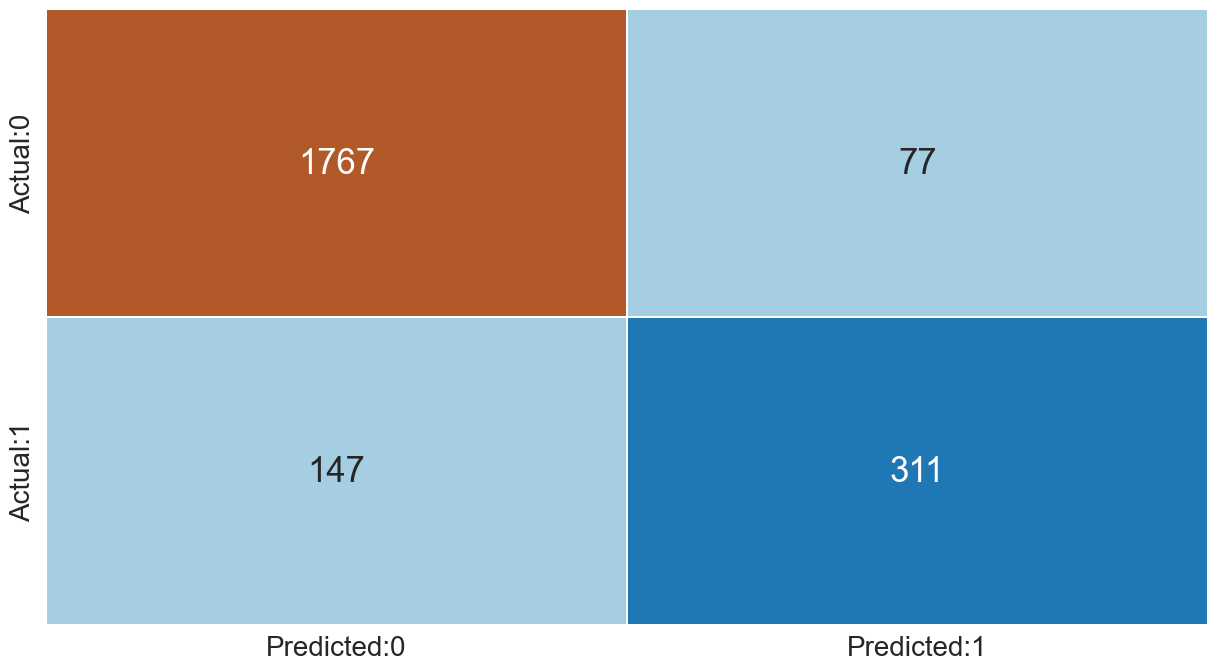

In [101]:
# Defining the size of the canvas
plt.rcParams['figure.figsize'] = [15, 8]

# Confusion matrix to DataFrame
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])

# Plotting the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Paired', cbar=False, linewidths=0.1, annot_kws={'size': 25})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [102]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1844
           1       0.80      0.68      0.74       458

    accuracy                           0.90      2302
   macro avg       0.86      0.82      0.84      2302
weighted avg       0.90      0.90      0.90      2302



# Logistic Regression

In [104]:
# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Create the Logistic Regression model
lr_model = LogisticRegression(random_state=42)

# Create the GridSearchCV object
lr_grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit the GridSearchCV to the data
lr_grid_search.fit(X_train_tfidf_balanced, y_train_balanced)

# Get the best parameters and best score
lr_best_params = lr_grid_search.best_params_
lr_best_score = lr_grid_search.best_score_

print("Logistic Regression Best Parameters:", lr_best_params)
print("Logistic Regression Best Accuracy:", lr_best_score)

Logistic Regression Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression Best Accuracy: 0.9619189699189701


In [105]:
# Convert the TF-IDF vectorized data to dense matrix
X_train_dense = X_train_tfidf_balanced.toarray()

# Use the best parameters to build the final Logistic Regression model
final_lr_model = LogisticRegression(**lr_best_params, random_state=42)
final_lr_model.fit(X_train_dense, y_train_balanced)

# Convert the TF-IDF vectorized test data to dense matrix
X_test_dense = X_test_tfidf.toarray()

# Make predictions on the test set using the final Logistic Regression model
y_pred_lr = final_lr_model.predict(X_test_dense)

# Calculate evaluation metrics
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr, average="weighted")
lr_recall = recall_score(y_test, y_pred_lr, average="weighted")
lr_f1 = f1_score(y_test, y_pred_lr, average="weighted")

# Print the evaluation metrics
print("Logistic Regression Final Model Accuracy:", lr_accuracy)
print("Logistic Regression Final Model Precision:", lr_precision)
print("Logistic Regression Final Model Recall:", lr_recall)
print("Logistic Regression Final Model F1 Score:", lr_f1)

Logistic Regression Final Model Accuracy: 0.9135534317984362
Logistic Regression Final Model Precision: 0.9148646915129781
Logistic Regression Final Model Recall: 0.9135534317984362
Logistic Regression Final Model F1 Score: 0.9141408320096905


In [106]:
# Building confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
cm

array([[1736,  108],
       [  91,  367]])

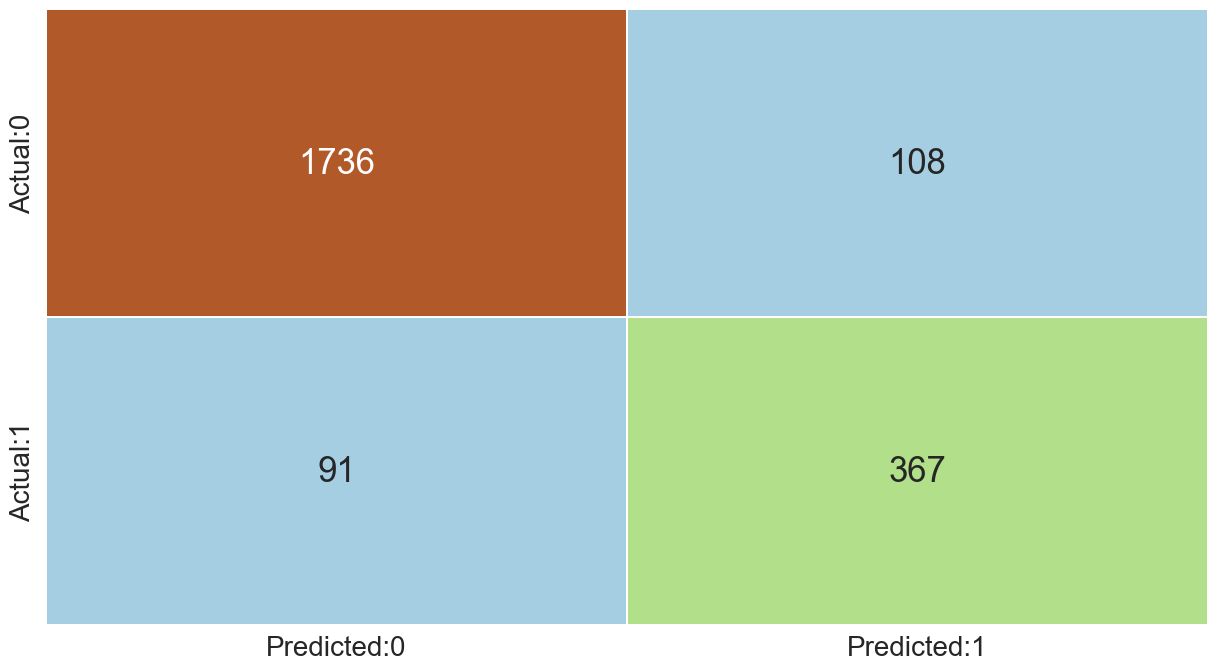

In [107]:
# Defining the size of the canvas
plt.rcParams['figure.figsize'] = [15, 8]

# Confusion matrix to DataFrame
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])

# Plotting the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Paired', cbar=False, linewidths=0.1, annot_kws={'size': 25})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [108]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1844
           1       0.77      0.80      0.79       458

    accuracy                           0.91      2302
   macro avg       0.86      0.87      0.87      2302
weighted avg       0.91      0.91      0.91      2302



# BERT

In [47]:
# Step 1: Load the data and split into train and test sets
# Assuming you already have X_train, y_train, X_test, and y_test

# Step 2: Create the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Step 3: Apply the BERT tokenizer to convert text data into numerical features
X_train_encoded = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='tf')
X_test_encoded = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors='tf')

# Step 4: Apply SMOTE to balance the class distribution on the training data
smote = SMOTE(random_state=42)
X_train_encoded_balanced, y_train_balanced = smote.fit_resample(X_train_encoded['input_ids'], y_train)

# Step 5: Create a function to build the BERT model with different hyperparameters
def build_model(hp):
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-6, 1e-4, sampling='log'))
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

# Step 6: Define the hyperparameter search space for Keras Tuner
tuner = RandomSearch(build_model, objective='accuracy', max_trials=5, directory='bert_tuner')

# Step 7: Perform hyperparameter tuning using Keras Tuner
tuner.search(X_train_encoded_balanced, y_train_balanced, epochs=3, batch_size=16, validation_split=0.1)

# Step 8: Get the best hyperparameters and build the final model
best_params = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_params)
best_model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


INFO:tensorflow:Reloading Tuner from bert_tuner/untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Step 9: Train the final model with the balanced training dataset
best_model.fit(X_train_encoded_balanced, y_train_balanced, epochs=3, batch_size=16)

# Step 10: Make predictions on the test set using the final model
y_pred = best_model.predict(X_test_encoded['input_ids'])
y_pred_labels = tf.argmax(y_pred.logits, axis=1)

# Step 11: Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels, average="weighted")
recall = recall_score(y_test, y_pred_labels, average="weighted")
f1 = f1_score(y_test, y_pred_labels, average="weighted")

# Step 12: Print the evaluation metrics
print("Final Model Accuracy:", accuracy)
print("Final Model Precision:", precision)
print("Final Model Recall:", recall)
print("Final Model F1 Score:", f1)

Epoch 1/3


2023-07-24 00:44:57.192166: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


915/915 [==============================] - 289s 298ms/step - loss: 0.2152 - accuracy: 0.9130
Epoch 2/3
915/915 [==============================] - 287s 313ms/step - loss: 0.1198 - accuracy: 0.9558
Epoch 3/3
72/72 [==============================] - 29s 340ms/step
Final Model Accuracy: 0.9157254561251086
Final Model Precision: 0.9172558818763153
Final Model Recall: 0.9157254561251086
Final Model F1 Score: 0.9163960690661668


In [51]:
# Make predictions on the test set using the final BERT model
y_pred_logits = y_pred.logits
y_pred_bert = tf.argmax(y_pred_logits, axis=1)

# Build the confusion matrix
cm = confusion_matrix(y_test, y_pred_bert)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1737  107]
 [  87  371]]


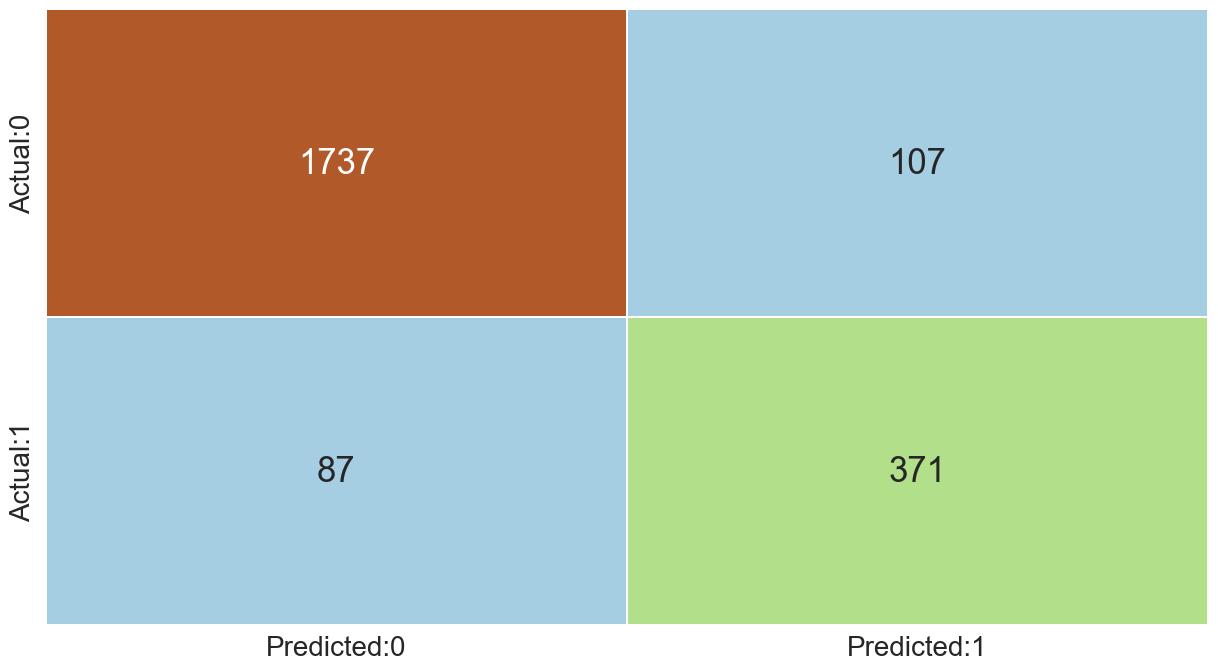

In [52]:
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])
plt.rcParams['figure.figsize'] = [15, 8]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Paired', cbar=False, linewidths=0.1, annot_kws={'size': 25})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [53]:
# Build the classification report
report = classification_report(y_test, y_pred_bert)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1844
           1       0.78      0.81      0.79       458

    accuracy                           0.92      2302
   macro avg       0.86      0.88      0.87      2302
weighted avg       0.92      0.92      0.92      2302



# LTSM

In [ ]:
# Apply TF-IDF Vectorizer to convert text data into numerical features
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Convert the TF-IDF vectorized data to dense matrix
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Encode the target labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Define the BiLSTM model
def create_bilstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=X_train_dense.shape[1], output_dim=128, input_length=X_train_dense.shape[1]))
    model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create the BiLSTM model
bilstm_model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_bilstm_model, epochs=10, batch_size=32, verbose=0)

# Define the parameter grid to search
param_grid = {
    'epochs': [10, 20],
    'batch_size': [32, 64],
    # 'merge_mode': ['concat', 'sum', 'ave', 'mul'],
}

# Perform GridSearchCV to find the best model
grid_search = GridSearchCV(estimator=bilstm_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)
grid_search.fit(X_train_dense, y_train_encoded)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)



Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
# Use the best parameters to build the final BiLSTM model
final_bilstm_model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_bilstm_model, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
final_bilstm_model.fit(X_train_dense, y_train_encoded)

# Make predictions on the test set using the final BiLSTM model
y_pred_bilstm = final_bilstm_model.predict(X_test_dense)

# Convert the encoded labels back to original class labels
y_pred_bilstm = le.inverse_transform(y_pred_bilstm)
y_test_original = le.inverse_transform(y_test_encoded)

# Calculate evaluation metrics
bilstm_accuracy = accuracy_score(y_test_original, y_pred_bilstm)
bilstm_precision = precision_score(y_test_original, y_pred_bilstm, average="weighted")
bilstm_recall = recall_score(y_test_original, y_pred_bilstm, average="weighted")
bilstm_f1 = f1_score(y_test_original, y_pred_bilstm, average="weighted")

# Print the evaluation metrics
print("BiLSTM Final Model Accuracy:", bilstm_accuracy)
print("BiLSTM Final Model Precision:", bilstm_precision)
print("BiLSTM Final Model Recall:", bilstm_recall)
print("BiLSTM Final Model F1 Score:", bilstm_f1)

In [ ]:
# Build the confusion matrix
cm_bilstm = confusion_matrix(y_test_original, y_pred_bilstm)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm_bilstm)

In [ ]:
# Build the classification report
classification_report_bilstm = classification_report(y_test_original, y_pred_bilstm)

# Print the classification report
print("Classification Report:")
print(classification_report_bilstm)

# Note:
In scikit-learn, GridSearchCV and RandomSearch have already perform cross-validation internally during the hyperparameter search. Additional cross-validation is not needed when using these classes, as they split the data into training and validation folds and evaluate the models using cross-validation to find the best hyperparameters automatically.

Here's how it works:

GridSearchCV: It exhaustively tries all the combinations of hyperparameters specified in the parameter grid and evaluates each combination using cross-validation. The best model and hyperparameters are selected based on the performance during cross-validation.

RandomSearch: It randomly samples a specified number of hyperparameter combinations from the parameter grid and evaluates each combination using cross-validation. The best model and hyperparameters are selected based on the performance during cross-validation.

So, you don't need to manually perform cross-validation on the best model obtained from GridSearchCV or RandomiSearch. The hyperparameter tuning and cross-validation are already handled internally by these classes.